In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import yfinance as yf

from invaas.poptions import poptions
from matplotlib.pyplot import figure
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=12, progress_bar=True, verbose=2)

%matplotlib widget
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

data_directory = "data/spy-options-data-2020-2022/"


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
periods = 20
# periods = 30  # BEST RESULT
fear_greed_window = 40

refresh_formatted_data = False
refresh_processed_data = False

raw_data_path = data_directory + "spy_2020_2022.csv"
formatted_data_path = data_directory + "spy_2020_2022_formatted.csv"
processed_data_path = data_directory + "spy_2020_2022_processed.csv"

if not refresh_processed_data and os.path.isfile(processed_data_path):
    df_options = pd.read_csv(processed_data_path, low_memory=False)
else:
    if not refresh_formatted_data and os.path.isfile(formatted_data_path):
        df_formatted = pd.read_csv(formatted_data_path, low_memory=False)
    else:
        df_formatted = pd.read_csv(raw_data_path, low_memory=False)

        columns = df_formatted.columns
        columns = [s.replace("[", "") for s in columns]
        columns = [s.replace("]", "") for s in columns]
        columns = [s.replace(" ", "") for s in columns]
        df_formatted.columns = columns

        date_columns = ["QUOTE_READTIME", "QUOTE_DATE", "EXPIRE_DATE"]
        numeric_cols = df_formatted.columns.to_list()
        numeric_cols.remove("QUOTE_READTIME")
        numeric_cols.remove("QUOTE_DATE")
        numeric_cols.remove("EXPIRE_DATE")

        df_formatted.drop(columns=date_columns, inplace=True)

        for i in numeric_cols:
            df_formatted[i] = pd.to_numeric(df_formatted[i], errors="coerce")

        df_formatted.drop(columns=["C_SIZE", "P_SIZE"], inplace=True)
        df_formatted["EXPIRE_UNIX"] = pd.to_datetime(df_formatted.EXPIRE_UNIX, unit="s", utc=True)
        df_formatted["QUOTE_UNIXTIME"] = pd.to_datetime(df_formatted.QUOTE_UNIXTIME, unit="s", utc=True).apply(
            lambda x: pd.Timestamp(x).round(freq="D")
        )
        df_formatted["OPTION_ID"] = (
            df_formatted["EXPIRE_UNIX"].astype(str) + df_formatted["STRIKE"].astype(str)
        ).apply(lambda x: hash(x))

        df_formatted.sort_values(by=["QUOTE_UNIXTIME", "EXPIRE_UNIX", "STRIKE"], inplace=True)

        for column in ["C_ASK", "P_ASK"]:
            max_ask_column = f"MAX_{column}_{periods}"
            min_ask_column = f"MIN_{column}_{periods}"
            max_column_rename = {}
            min_column_rename = {}
            max_column_rename[column] = max_ask_column
            min_column_rename[column] = min_ask_column
            df_formatted.drop(columns=[max_ask_column, min_ask_column], errors="ignore", inplace=True)
            df_rolling_max_ask = (
                df_formatted.groupby("OPTION_ID", as_index=False)[column]
                .rolling(window=periods, min_periods=1)
                .max()
                .rename(columns=max_column_rename)
                .drop(columns=["OPTION_ID"])
                .join(df_formatted)[["OPTION_ID", max_ask_column]]
                .groupby("OPTION_ID", as_index=False)
                .shift(periods=-periods)
                .join(df_formatted)[["OPTION_ID", max_ask_column]]
                .drop(columns=["OPTION_ID"])
            )
            df_rolling_min_ask = (
                df_formatted.groupby("OPTION_ID", as_index=False)[column]
                .rolling(window=periods, min_periods=1)
                .min()
                .rename(columns=min_column_rename)
                .drop(columns=["OPTION_ID"])
                .join(df_formatted)[["OPTION_ID", min_ask_column]]
                .groupby("OPTION_ID", as_index=False)
                .shift(periods=-periods)
                .join(df_formatted)[["OPTION_ID", min_ask_column]]
                .drop(columns=["OPTION_ID"])
            )
            df_formatted = df_formatted.join(df_rolling_max_ask)
            df_formatted = df_formatted.join(df_rolling_min_ask)

        df_formatted_total_options = (
            df_formatted.groupby("OPTION_ID", as_index=False).size().rename(columns={"size": "total"})
        )
        df_formatted = df_formatted.loc[
            df_formatted.OPTION_ID.isin(
                df_formatted_total_options.loc[df_formatted_total_options.total > periods].OPTION_ID
            )
        ]

        with open("data/cnn_fear_greed_index_data.json") as f:
            cnn_fear_greed_index_data = json.load(f)

        df_fear_greed_index = pd.DataFrame(
            data=cnn_fear_greed_index_data["data"]["c:50108"]["series"][0], columns=["x", "y"]
        )
        df_fear_greed_index["QUOTE_UNIXTIME"] = pd.DatetimeIndex(
            [pd.Timestamp(x, unit="s", tz="UTC") for x in df_fear_greed_index.x]
        )
        df_fear_greed_index.rename(columns={"y": "fear_greed_index"}, inplace=True)
        df_fear_greed_index["fear_greed_index"] = df_fear_greed_index.fear_greed_index.astype(float).round().shift()
        df_fear_greed_index[f"fear_greed_index_max_{fear_greed_window}"] = df_fear_greed_index.fear_greed_index.rolling(
            window=fear_greed_window, min_periods=fear_greed_window
        ).max()
        df_fear_greed_index[f"fear_greed_index_min_{fear_greed_window}"] = df_fear_greed_index.fear_greed_index.rolling(
            window=fear_greed_window, min_periods=fear_greed_window
        ).min()
        df_formatted = df_formatted.merge(
            df_fear_greed_index[
                [
                    "QUOTE_UNIXTIME",
                    "fear_greed_index",
                    f"fear_greed_index_max_{fear_greed_window}",
                    f"fear_greed_index_min_{fear_greed_window}",
                ]
            ],
            on="QUOTE_UNIXTIME",
            how="left",
        )

        # df_irx_history = yf.Ticker("^IRX").history(interval="1d", period="5y")
        # df_irx_history.columns = [f"IRX_{x}" for x in map(str.lower, df_irx_history.columns)]
        # df_irx_history["QUOTE_UNIXTIME"] = [
        #     pd.to_datetime(x, utc=True).round(freq="D") for x in df_irx_history.index.values
        # ]
        # df_formatted = df_formatted.merge(
        #     df_irx_history[["QUOTE_UNIXTIME", "IRX_close"]], on="QUOTE_UNIXTIME", how="inner"
        # )

        df_formatted.reset_index(inplace=True, drop=True)
        df_formatted.to_csv(formatted_data_path, index=False)

    def get_options_data(row):
        return [
            {
                "option_id": hash("call" + str(row.OPTION_ID)),
                "option_type": "call",
                "quote_unixtime": row.QUOTE_UNIXTIME,
                "expire_unixtime": row.EXPIRE_UNIX,
                "days_to_expire": row.DTE,
                "underlying_last": row.UNDERLYING_LAST,
                "strike": row.STRIKE,
                "strike_distance": row.STRIKE_DISTANCE,
                "strike_distance_pct": row.STRIKE_DISTANCE_PCT,
                "delta": row.C_DELTA,
                "gamma": row.C_GAMMA,
                "vega": row.C_VEGA,
                "theta": row.C_THETA,
                "rho": row.C_RHO,
                "iv": row.C_IV,
                "volume": row.C_VOLUME,
                "last": row.C_LAST,
                "bid": row.C_BID,
                "ask": row.C_ASK,
                "max_ask": row[f"MAX_C_ASK_{periods}"],
                "min_ask": row[f"MIN_C_ASK_{periods}"],
                # "irx": row.IRX_close,
                "fear_greed_index": row.fear_greed_index,
                "fear_greed_index_max": row[f"fear_greed_index_max_{fear_greed_window}"],
                "fear_greed_index_min": row[f"fear_greed_index_min_{fear_greed_window}"],
            },
            {
                "option_id": hash("put" + str(row.OPTION_ID)),
                "option_type": "put",
                "quote_unixtime": row.QUOTE_UNIXTIME,
                "expire_unixtime": row.EXPIRE_UNIX,
                "days_to_expire": row.DTE,
                "underlying_last": row.UNDERLYING_LAST,
                "strike": row.STRIKE,
                "strike_distance": row.STRIKE_DISTANCE,
                "strike_distance_pct": row.STRIKE_DISTANCE_PCT,
                "delta": row.P_DELTA,
                "gamma": row.P_GAMMA,
                "vega": row.P_VEGA,
                "theta": row.P_THETA,
                "rho": row.P_RHO,
                "iv": row.P_IV,
                "volume": row.P_VOLUME,
                "last": row.P_LAST,
                "bid": row.P_BID,
                "ask": row.P_ASK,
                "max_ask": row[f"MAX_P_ASK_{periods}"],
                "min_ask": row[f"MIN_P_ASK_{periods}"],
                # "irx": row.IRX_close,
                "fear_greed_index": row.fear_greed_index,
                "fear_greed_index_max": row[f"fear_greed_index_max_{fear_greed_window}"],
                "fear_greed_index_min": row[f"fear_greed_index_min_{fear_greed_window}"],
            },
        ]

    def flatten(xss):
        return [x for xs in xss for x in xs]

    options_data = flatten(df_formatted[: len(df_formatted)].parallel_apply(get_options_data, axis=1))
    df_options = pd.DataFrame(data=options_data)
    df_options.to_csv(processed_data_path, index=False)

df_options

,option_id,option_type,quote_unixtime,expire_unixtime,days_to_expire,underlying_last,strike,strike_distance,strike_distance_pct,delta,gamma,vega,theta,rho,iv,volume,last,bid,ask,max_ask,min_ask,fear_greed_index,fear_greed_index_max,fear_greed_index_min
0,8228026009228119508,call,2020-01-03 00:00:00+00:00,2020-01-31 21:00:00+00:00,29.00,324.87,255.0,69.9,0.215,0.99254,0.00067,0.01952,-0.01130,0.20686,0.35727,1.0,66.82,69.87,70.05,77.27,67.22,NaN,NaN,NaN
1,8388765138564423602,put,2020-01-03 00:00:00+00:00,2020-01-31 21:00:00+00:00,29.00,324.87,255.0,69.9,0.215,-0.00379,0.00033,0.01031,-0.00484,-0.00110,0.32142,16.0,0.03,0.03,0.04,0.04,0.01,NaN,NaN,NaN
2,1027550724891153287,call,2020-01-03 00:00:00+00:00,2020-01-31 21:00:00+00:00,29.00,324.87,260.0,64.9,0.200,0.98654,0.00101,0.03238,-0.01868,0.20993,0.36143,10.0,60.50,64.94,65.13,72.30,62.23,NaN,NaN,NaN
3,-1534760388604062099,put,2020-01-03 00:00:00+00:00,2020-01-31 21:00:00+00:00,29.00,324.87,260.0,64.9,0.200,-0.00465,0.00052,0.01345,-0.00650,-0.00176,0.30648,3.0,0.04,0.04,0.05,0.05,0.01,NaN,NaN,NaN
4,-6171319654666929667,call,2020-01-03 00:00:00+00:00,2020-01-31 21:00:00+00:00,29.00,324.87,265.0,59.9,0.184,0.97933,0.00146,0.04691,-0.02728,0.21135,0.35875,NaN,0.00,60.01,60.26,67.28,57.21,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6705099,2688229576149051334,put,2022-12-31 00:00:00+00:00,2025-03-21 20:00:00+00:00,811.96,382.44,590.0,207.6,0.543,-1.00000,0.00000,0.00000,0.00000,0.00000,NaN,NaN,0.00,202.75,210.00,NaN,NaN,37.0,76.0,36.0
6705100,4933943145329079888,call,2022-12-31 00:00:00+00:00,2025-03-21 20:00:00+00:00,811.96,382.44,595.0,212.6,0.556,0.09466,0.00169,0.96298,-0.01292,0.72396,0.17885,NaN,0.00,1.73,6.50,NaN,NaN,37.0,76.0,36.0
6705101,-7427531086436162822,put,2022-12-31 00:00:00+00:00,2025-03-21 20:00:00+00:00,811.96,382.44,595.0,212.6,0.556,-0.90719,0.00326,0.61124,-0.00505,-1.24251,0.28500,NaN,0.00,207.82,217.78,NaN,NaN,37.0,76.0,36.0
6705102,4838387660868289251,call,2022-12-31 00:00:00+00:00,2025-03-21 20:00:00+00:00,811.96,382.44,600.0,217.6,0.569,0.09424,0.00161,0.95513,-0.01327,0.71483,0.18161,0.0,4.60,2.25,6.00,NaN,NaN,37.0,76.0,36.0


In [3]:
df_options.describe().astype(str)

,option_id,days_to_expire,underlying_last,strike,strike_distance,strike_distance_pct,delta,gamma,vega,theta,rho,iv,volume,last,bid,ask,max_ask,min_ask,fear_greed_index,fear_greed_index_max,fear_greed_index_min
count,6705104.0,6705104.0,6705104.0,6705104.0,6705104.0,6705104.0,6704718.0,6704718.0,6704718.0,6704718.0,6704718.0,6379498.0,5430040.0,6703192.0,6703192.0,6703192.0,4604612.0,4604612.0,3104976.0,2800326.0,2800326.0
mean,-4.526365433370833e+16,165.569171150813,387.19143309932264,367.258820146563,71.87527549162552,0.18726444332556216,0.05852685361114359,-5.539010259172714,-4.591413383244466,-0.06525248893689488,-0.13273299260908508,0.3319192409606522,248.14380299224314,24.879528029332892,41.13185712567984,42.06987972297378,55.65678393966744,41.49223490491715,39.144283884964004,60.48275165105777,16.130365536012594
std,5.333833272350877e+18,205.26504897883348,56.119759445888285,110.414241734368,69.74638091674225,0.17758214171887793,0.6172408840004929,7265.928700629256,65.35914030587458,0.33726956602471037,4.943414620970326,0.3911653863338513,2996.713572218119,44.36007231067608,58.043199584864254,58.7510679326706,66.81435376928155,59.465487793705336,16.75612826873928,10.61192060858786,8.59627846749676
min,-9.223336797429473e+18,0.0,222.21,5.0,0.0,0.0,-1.0,-14950363.96601,-2815.39969,-45.23137,-2878.27141,-0.0005,0.0,0.0,0.0,0.0,0.01,0.0,3.0,39.0,3.0
25%,-4.707991387036329e+18,23.0,342.65,299.0,21.6,0.056,-0.34296,0.00062,0.07026,-0.07495,-0.17122,0.18541,0.0,0.06,1.88,2.08,6.61,1.83,26.0,48.0,11.0
50%,-8.316397478915686e+16,80.0,393.97,368.0,49.8,0.131,0.0,0.00297,0.29822499999999996,-0.04169,0.0,0.25123,3.0,5.32,16.7,17.46,29.95,15.26,37.0,62.0,14.0
75%,4.563451068124375e+18,235.04,434.37,437.0,103.6,0.273,0.6565274999999999,0.00649,0.73064,-0.01626,0.17039,0.35641,30.0,29.33,55.64,57.21,80.71,56.47,53.0,68.0,19.0
max,9.223331946358249e+18,1096.0,477.77,4898.0,4469.3,10.425,1.0,10.99989,147.32807,0.0,357.46355,52.10104,381807.0,444.2,4451.19,4455.5,4455.5,4455.5,77.0,77.0,52.0


In [193]:
# min_dte = periods
# min_dte = 20
# max_dte = 30
min_dte = 30  # BEST RESULT
max_dte = 90  # BEST RESULT
max_ask = 10
# min_ask = max_ask / 10
min_ask = 0.2
min_volume = 100
max_strike_distance_pct = 0.1
target_profit = 1.1

df_options_filtered = df_options.loc[
    (df_options.fear_greed_index_max.notnull())
    & (df_options.bid > 0)
    & (df_options.ask > 0)
    & (df_options.ask < max_ask)
    & (df_options.ask > min_ask)
    & (df_options.volume > min_volume)
    & (df_options.strike_distance_pct < max_strike_distance_pct)
    & (df_options.days_to_expire > min_dte)
    & (df_options.days_to_expire < max_dte)
]
# [
#     [
#         "option_type",
#         "underlying_last",
#         "strike",
#         "ask",
#         "days_to_expire",
#         "iv",
#         # "irx",
#     ]
# ].drop_duplicates()


# def get_pop(row):
#     # if (row.underlying_last * row.strike * row.ask * row.days_to_expire * row.iv) == 0:
#     #     return 0

#     pop_func = poptions.longCall if row.option_type == "call" else poptions.longPut
#     pop_data = pop_func(
#         underlying=row.underlying_last,
#         long_strike=row.strike,
#         long_price=row.ask,
#         days_to_expiration=int(row.days_to_expire),
#         closing_days_array=[(periods if periods < row.days_to_expire else int(row.days_to_expire))],
#         sigma=row.iv * 100,
#         rate=0,
#         # rate=row.irx,
#         trials=100,
#         multiple_array=[target_profit],
#     )
#     # print(pop_data)
#     return {"pop": pop_data["pop"][0], "pop_error": pop_data["pop_error"][0]}


# # pops = []
# # num = 0
# # total = len(df_options_filtered)

# # for index, row in df_options_filtered.iterrows():
# #     num += 1
# #     print(f"{num}/{total} -- ({num/total*100:.2f}%)", end="\r")
# #     pops.append(get_pop(row))

# # df_options_filtered["pop"] = pops

# pops = df_options_filtered.parallel_apply(get_pop, axis=1)
# df_options_filtered["probability_of_profit"] = [x["pop"] for x in pops]
# df_options_filtered["probability_of_profit_error"] = [x["pop_error"] for x in pops]

df_options_filtered.dropna(subset=["max_ask", "min_ask"], inplace=True)
df_options_filtered

/var/folders/86/qt4jnsg167j7h7mqgbpp44kh0000gn/T/ipykernel_180/3819712389.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_options_filtered.dropna(subset=["max_ask", "min_ask"], inplace=True)


,option_id,option_type,quote_unixtime,expire_unixtime,days_to_expire,underlying_last,strike,strike_distance,strike_distance_pct,delta,gamma,vega,theta,rho,iv,volume,last,bid,ask,max_ask,min_ask,fear_greed_index,fear_greed_index_max,fear_greed_index_min
3412233,-7284403565423334204,put,2021-07-14 00:00:00+00:00,2021-08-13 20:00:00+00:00,31.0,435.72,395.0,40.7,0.093,-0.07773,0.00470,0.18849,-0.07067,-0.02999,0.24072,120.0,1.08,1.11,1.13,2.28,0.02,30.0,54.0,27.0
3412237,-6900012193074301262,put,2021-07-14 00:00:00+00:00,2021-08-13 20:00:00+00:00,31.0,435.72,397.0,38.7,0.089,-0.08554,0.00515,0.20168,-0.07453,-0.03375,0.23642,116.0,1.22,1.21,1.24,2.47,0.02,30.0,54.0,27.0
3412239,6126913891936646503,put,2021-07-14 00:00:00+00:00,2021-08-13 20:00:00+00:00,31.0,435.72,398.0,37.7,0.087,-0.08839,0.00531,0.20656,-0.07547,-0.03429,0.23418,135.0,1.18,1.26,1.27,2.58,0.02,30.0,54.0,27.0
3412243,-8542137146864587244,put,2021-07-14 00:00:00+00:00,2021-08-13 20:00:00+00:00,31.0,435.72,400.0,35.7,0.082,-0.09611,0.00578,0.22012,-0.07855,-0.03787,0.22859,153.0,1.37,1.36,1.37,2.77,0.03,30.0,54.0,27.0
3412245,8889578099934366041,put,2021-07-14 00:00:00+00:00,2021-08-13 20:00:00+00:00,31.0,435.72,401.0,34.7,0.080,-0.10012,0.00609,0.22682,-0.07972,-0.03952,0.22649,118.0,1.42,1.41,1.43,2.88,0.03,30.0,54.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6588412,8926636401208964267,call,2022-12-02 00:00:00+00:00,2023-02-17 21:00:00+00:00,78.0,407.40,437.0,29.6,0.073,0.22074,0.00895,0.56191,-0.06749,0.18591,0.17425,146.0,4.04,4.01,4.05,3.59,0.24,76.0,76.0,16.0
6588414,-8802341623244967839,call,2022-12-02 00:00:00+00:00,2023-02-17 21:00:00+00:00,78.0,407.40,438.0,30.6,0.075,0.21088,0.00880,0.54746,-0.06536,0.17741,0.17288,127.0,3.83,3.77,3.79,3.37,0.22,76.0,76.0,16.0
6588418,-6999102162049648074,call,2022-12-02 00:00:00+00:00,2023-02-17 21:00:00+00:00,78.0,407.40,440.0,32.6,0.080,0.19374,0.00842,0.52021,-0.06182,0.16305,0.17215,111.0,3.40,3.36,3.39,2.94,0.19,76.0,76.0,16.0
6588426,-4637813185526554528,call,2022-12-02 00:00:00+00:00,2023-02-17 21:00:00+00:00,78.0,407.40,444.0,36.6,0.090,0.16013,0.00761,0.46192,-0.05323,0.13561,0.16914,173.0,2.61,2.60,2.63,2.26,0.14,76.0,76.0,16.0


In [5]:
# df_options_filtered.describe().astype(str)
# df_options_filtered.loc[df_options_filtered.probability_of_profit > 0]
# df_options_filtered.loc[df_options_filtered.probability_of_profit > 0].groupby("option_type", as_index=False).size()

# processed_filtered_data_path = data_directory + "spy_2020_2022_processed_filtered.csv"
# # df_options_filtered.to_csv(processed_filtered_data_path, index=False)
# # df_options_filtered = pd.read_csv(processed_filtered_data_path, low_memory=False)

In [6]:
# df_options.drop(columns=["probability_of_profit", "probability_of_profit_error"], errors="ignore", inplace=True)
# df_options = df_options.join(df_options_filtered[["probability_of_profit", "probability_of_profit_error"]], how="left")
# df_options

In [7]:
# df_options["ask_pct_diff"] = (df_options.max_ask - df_options.ask) / df_options.ask
# df_options.describe().astype(str)

# df_options_filtered["max_ask_pct_diff"] = (
#     df_options_filtered.max_ask - df_options_filtered.ask
# ) / df_options_filtered.ask
# df_options_filtered["min_ask_pct_diff"] = (
#     df_options_filtered.min_ask - df_options_filtered.ask
# ) / df_options_filtered.ask
# df_options_filtered.describe().astype(str)

In [194]:
# min_probability_of_profit = 0
# df_options["did_buy"] = (
#     # (df_options.probability_of_profit > min_probability_of_profit)
#     (df_options.fear_greed_index == df_options.fear_greed_index_max)
#     | (df_options.fear_greed_index == df_options.fear_greed_index_min)
#     # (
#     #     ((df_options.option_type == "call") & (df_options.fear_greed_index == df_options.fear_greed_index_max))
#     #     | ((df_options.option_type == "put") & (df_options.fear_greed_index == df_options.fear_greed_index_min))
#     # )
# )
# df_options["should_buy"] = df_options.max_ask > (df_options.ask * target_profit)
# df_options.groupby(["did_buy", "should_buy"], as_index=False).size()
# # df_options.loc[df_options.did_buy].groupby(["quote_unixtime", "did_buy", "should_buy"], as_index=False).size()

min_fear_greed_index_threshold = 30
max_fear_greed_index_threshold = 70
max_diff = 0

df_options_filtered["did_buy"] = (
    (df_options_filtered.option_type == "call")
    & (
        (df_options_filtered.fear_greed_index < min_fear_greed_index_threshold)
        # & (df_options_filtered.fear_greed_index <= (df_options_filtered.fear_greed_index_min + max_diff))
    )
) | (
    (df_options_filtered.option_type == "put")
    & (
        (df_options_filtered.fear_greed_index > max_fear_greed_index_threshold)
        # & (df_options_filtered.fear_greed_index >= (df_options_filtered.fear_greed_index_max - max_diff))
    )
)
# df_options_filtered["did_buy"] = (
#     (df_options_filtered.fear_greed_index == df_options_filtered.fear_greed_index_min)
# ) | ((df_options_filtered.fear_greed_index == df_options_filtered.fear_greed_index_max))
df_options_filtered["should_buy"] = df_options_filtered.max_ask > (df_options_filtered.ask * target_profit)
# df_options_filtered["should_buy"] = df_options_filtered.max_ask >= (df_options_filtered.ask * 0.5)
# df_options_filtered["should_buy"] = df_options_filtered.max_ask_pct_diff > 0

total_gains = (
    df_options_filtered.loc[df_options_filtered.did_buy & df_options_filtered.should_buy].ask
    * (target_profit - 1)
    * 100
).sum()
# total_gains = (df_options_filtered.loc[df_options_filtered.did_buy & df_options_filtered.should_buy].ask * (0.5) * 100).sum()

max_loss = -1 if (1 - target_profit) < -1 else (1 - target_profit)
total_losses = (
    df_options_filtered.loc[df_options_filtered.did_buy & (~df_options_filtered.should_buy)].ask * max_loss * 100
).sum()
print(f"Total gains: ${total_gains:.2f}")
print(f"Total losses: ${total_losses:.2f}")
print(f"Total profit: ${total_gains + total_losses:.2f}")
df_options_filtered.groupby(["did_buy", "should_buy"], as_index=False).size()
# df_options.loc[df_options.did_buy].groupby(["quote_unixtime", "did_buy", "should_buy"], as_index=False).size()

Total gains: $291584.90
Total losses: $-20822.20
Total profit: $270762.70


/var/folders/86/qt4jnsg167j7h7mqgbpp44kh0000gn/T/ipykernel_180/2931737422.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_options_filtered["did_buy"] = (
/var/folders/86/qt4jnsg167j7h7mqgbpp44kh0000gn/T/ipykernel_180/2931737422.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_options_filtered["should_buy"] = df_options_filtered.max_ask > (df_options_filtered.ask * target_profit)


,did_buy,should_buy,size
0,False,False,9655
1,False,True,19956
2,True,False,581
3,True,True,6400


In [196]:
money = 1000
start_money = money
# max_buy_price = max_ask * 100
# min_buy_price = min_ask * 100
contract_fee = 0
max_buy_amount = 1
total_contracts = 1
max_owned_option_type = 100
min_gain_pct = target_profit - 1
# min_gain_pct = 0.1
max_loss_pct = -1 if (1 - target_profit) < -1 else (1 - target_profit)
# max_loss_pct = -1

first_quote_datetime = pd.to_datetime(
    df_options.loc[df_options.fear_greed_index_max.notnull()].quote_unixtime.values[0]
)
last_quote_datetime = pd.to_datetime(df_options.quote_unixtime.values[-1])
last_quote_date = last_quote_datetime.strftime(format="%Y-%m-%d")

# df_options_total = df_options.groupby("option_id", as_index=False).size().rename(columns={"size": "total"})
df_options_simulate = df_options.loc[
    # df_options.option_id.isin(df_options_total.loc[df_options_total.total > 30].option_id)
    (pd.to_datetime(df_options.quote_unixtime) >= first_quote_datetime)
    & df_options.option_id.isin(
        df_options[
            # df_options.probability_of_profit.notna()
            # & (df_options.probability_of_profit >= min_probability_of_profit)
            df_options.fear_greed_index_max.notnull()
            # & (
            #     (df_options.fear_greed_index == df_options.fear_greed_index_max)
            #     | (df_options.fear_greed_index == df_options.fear_greed_index_min)
            # )
            & (
                (
                    (df_options.option_type == "call")
                    & (
                        (df_options.fear_greed_index < min_fear_greed_index_threshold)
                        # | (df_options.fear_greed_index <= (df_options.fear_greed_index_min + max_diff))
                    )
                )
                | (
                    (df_options.option_type == "put")
                    & (
                        (df_options.fear_greed_index > max_fear_greed_index_threshold)
                        # | (df_options.fear_greed_index >= (df_options.fear_greed_index_max - max_diff))
                    )
                )
            )
            & (df_options.bid > 0)
            & (df_options.ask > 0)
            & (df_options.ask < max_ask)
            & (df_options.ask > min_ask)
            & (df_options.volume > min_volume)
            & (df_options.strike_distance_pct < max_strike_distance_pct)
            & (df_options.days_to_expire > min_dte)
            & (df_options.days_to_expire < max_dte)
        ].option_id
    )
].sort_values(
    by=["quote_unixtime", "expire_unixtime", "ask", "strike_distance_pct"], ascending=[True, True, False, True]
)

owned_options = []
trade_data = []

num = 0
total = len(df_options_simulate)
total_days = (last_quote_datetime - first_quote_datetime).days

for index, row in df_options_simulate.iterrows():
    expire_date = pd.to_datetime(row.expire_unixtime).strftime(format="%Y-%m-%d")
    quote_date = pd.to_datetime(row.quote_unixtime).strftime(format="%Y-%m-%d")
    is_last_quote_date = quote_date == last_quote_date
    num += 1

    if num == total or num % 100 == 0:
        # days_remaining = (last_quote_datetime - pd.to_datetime(row.quote_unixtime)).days
        days_passed = (pd.to_datetime(row.quote_unixtime) - first_quote_datetime).days
        print(
            f"{num/total*100:.2f}% ({num}/{total}) -- {quote_date} ({days_passed}/{total_days}) -- {len(trade_data)} trades",
            end="\r",
        )

    # if row.option_id != -438094404447850621:
    #     continue

    owned_options_not_sold = []
    sold_options = 0

    good_buy = (
        (row.option_type == "call")
        and (
            (row.fear_greed_index < min_fear_greed_index_threshold)
            # or (row.fear_greed_index <= (row.fear_greed_index_min + max_diff))
        )
    ) or (
        (row.option_type == "put")
        and (
            (row.fear_greed_index > max_fear_greed_index_threshold)
            # or (row.fear_greed_index >= (row.fear_greed_index_max - max_diff))
        )
    )

    for option in owned_options:
        is_option = option["option_id"] == row.option_id
        days_to_expire = (
            option["days_to_expire"]
            - (pd.to_datetime(row.quote_unixtime) - pd.to_datetime(option["quote_unixtime"])).days
        )
        purchase_price = option["ask"] * 100
        bid_price = 0 if not is_option or np.isnan(row.bid) else row.bid * 100
        pct_diff = (bid_price - purchase_price) / purchase_price

        # if is_option and option["option_id"] == -438094404447850621:
        #     print(quote_date, option["days_to_expire"], bid_price, purchase_price, pct_diff, min_gain_pct, max_loss_pct)

        if (
            is_last_quote_date
            or days_to_expire <= 1
            # or (is_option and (not good_buy or (pct_diff > min_gain_pct or pct_diff < max_loss_pct)))
            or (is_option and (pct_diff > min_gain_pct or pct_diff < max_loss_pct))
        ):
            sold_options += 1
            money += (bid_price - contract_fee) * total_contracts
            print(
                f"{quote_date} ${money:.0f} {len(owned_options)-sold_options} sell {option['option_type']} {expire_date} {option['underlying_last']} {option['strike']} ${bid_price:.0f} {option['option_id']}"
            )
            trade_data.append(
                {
                    "id": option["option_id"],
                    "date": quote_date,
                    "money": money,
                    "side": "sell",
                    "type": option["option_type"],
                    "price": bid_price,
                    "options": len(owned_options) - sold_options,
                    "days_to_expire": option["days_to_expire"],
                }
            )
        else:
            owned_options_not_sold.append(option)

    owned_options = owned_options_not_sold

    # max_buy_price = money
    max_buy_price = 1000
    min_buy_price = 20

    if (
        # not np.isnan(row.probability_of_profit)
        # and row.probability_of_profit > min_probability_of_profit
        pd.notnull(row.fear_greed_index_max)
        # and ((row.fear_greed_index == row.fear_greed_index_max) or (row.fear_greed_index == row.fear_greed_index_min))
        and good_buy
        and not np.isnan(row.ask)
        and row.volume > min_volume
        and row.strike_distance_pct < max_strike_distance_pct
        and row.days_to_expire > min_dte
        and row.days_to_expire < max_dte
        and row.days_to_expire < (last_quote_datetime - pd.to_datetime(row.quote_unixtime)).days
        and len([x for x in owned_options if x["option_id"] == row.option_id]) == 0
        and len([x for x in owned_options if x["option_type"] == "call"]) < max_owned_option_type
        and len([x for x in owned_options if x["option_type"] == "put"]) < max_owned_option_type
        and (len([x for x in owned_options if x["purchase_date"] == quote_date]) < max_buy_amount)
    ):
        ask_price = row.ask * 100

        if ask_price <= max_buy_price and ask_price >= min_buy_price and money >= ask_price:
            money -= (ask_price + contract_fee) * total_contracts
            option_to_buy = row.to_dict()
            option_to_buy["side"] = "call"
            option_to_buy["purchase_date"] = quote_date
            owned_options.append(option_to_buy)
            print(
                f"{quote_date} ${money:.0f} {len(owned_options)} buy {row.option_type} {expire_date} {row.underlying_last} {row.strike} ${ask_price:.0f} {row.option_id}"
            )
            trade_data.append(
                {
                    "id": row.option_id,
                    "date": quote_date,
                    "money": money,
                    "side": "buy",
                    "type": row.option_type,
                    "price": ask_price,
                    "options": len(owned_options),
                    "days_to_expire": row.days_to_expire,
                }
            )

print()
print(f"Start money: ${start_money:.2f}")
print(f"End money: ${money:.2f} ({(money-start_money)/start_money*100:.2f}%)")

2021-07-16 $498 1 buy call 2021-08-16 434.65 437.0 $502 -1865698200678983814
2021-07-17 $859 0 sell call 2021-08-16 434.65 437.0 $361 -1865698200678983814
2021-07-20 $68 1 buy call 2021-08-20 424.93 426.0 $791 6092063339491207880
2021-07-21 $1187 0 sell call 2021-08-20 424.93 426.0 $1119 6092063339491207880
2021-07-21 $210 1 buy call 2021-08-20 431.07 428.0 $977 -1185068340927692827
2021-07-22 $1348 0 sell call 2021-08-20 431.07 428.0 $1138 -1185068340927692827
2021-07-22 $409 1 buy call 2021-08-23 434.55 431.0 $939 3385326396673909677
2021-07-23 $291 2 buy call 2021-08-23 435.51 448.0 $118 -5309762386563909929
2021-07-24 $1552 1 sell call 2021-08-23 434.55 431.0 $1261 3385326396673909677
2021-07-24 $1756 0 sell call 2021-08-23 435.51 448.0 $204 -5309762386563909929
2021-07-28 $756 1 buy call 2021-08-27 439.04 435.0 $1000 7246836258143352990
2021-07-29 $49 2 buy call 2021-08-30 438.86 439.0 $707 -8080567427382485175
2021-07-31 $944 1 sell call 2021-08-27 439.04 435.0 $895 7246836258143

In [121]:
# # "2021-08-17"
# df_options_simulate.loc[(df_options_simulate.option_id == -438094404447850621)][["quote_unixtime", "ask", "bid"]]

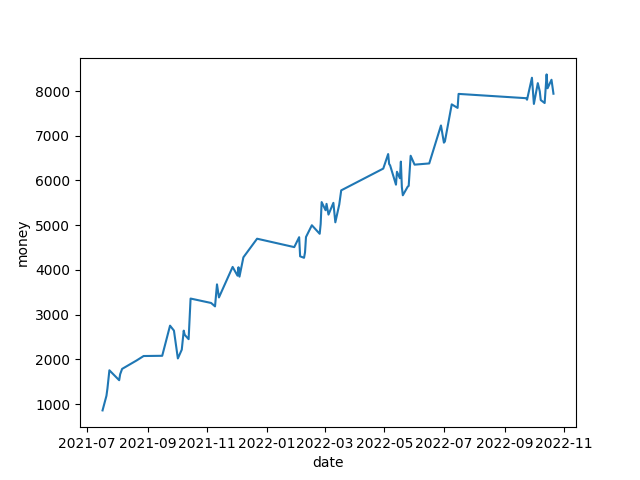

Total trades: 119
Good trades: 66 (55.46%)
Min Diff: $-568.00
Max Diff: $798.00
Min Pct. Change: -70.07%
Max Pct. Change: 86.21%


,id,money,price,options,days_to_expire,diff,pct_change
count,238.0,238.0,238.0,238.0,238.0,121.0,121.0
mean,1.088679911937857e+18,4363.226890756303,748.3781512605042,0.8865546218487395,32.564033613445375,62.88429752066115,7.358488549399297
std,4.863282538880341e+18,2241.079703005496,349.2388104057368,0.7684083357314562,2.18777821881706,248.59576257057174,37.31522437169087
min,-8.996070546301766e+18,49.0,44.0,0.0,30.04,-567.9999999999998,-70.06802721088435
25%,-1.9728861802265032e+18,2496.5,507.75,0.0,31.0,-151.0,-21.79627601314349
50%,1.1411129678916947e+18,4715.0,807.0,1.0,32.0,88.0,15.02890173410405
75%,5.089659152631614e+18,6089.75,980.75,1.0,33.0,263.0,38.46153846153848
max,9.107928447585857e+18,8372.0,1761.0,4.0,44.0,797.9999999999999,86.20689655172413


In [197]:
df_trades = pd.DataFrame(trade_data)
# df_trades = df_trades.loc[df_trades["type"] == "call"]

df_trades["diff"] = df_trades.groupby("id")["price"].diff()
df_trades["pct_change"] = df_trades.groupby("id")["price"].pct_change() * 100

field_to_plot = "money"
# df_trades_plot = df_trades_plot.copy()
# df_trades_plot = df_trades.loc[(df_trades["side"] == "sell")]
df_trades_plot = df_trades.loc[(df_trades["side"] == "sell") & (df_trades["options"] == 0)]

# field_to_plot = "options"
# df_trades_plot = df_trades.groupby(["date"]).max("options").reset_index()

fig = figure(figsize=(13, 4), dpi=80)

plt.close(fig)
plt.clf()
plt.plot(pd.to_datetime(df_trades_plot["date"]), df_trades_plot[field_to_plot])
plt.xlabel("date")
plt.ylabel(field_to_plot)
plt.show()

total_trades = len(df_trades.loc[df_trades["side"] == "sell"])
good_trades = (df_trades.dropna()["diff"] > 0).sum()
print(f"Total trades: {total_trades}")
print(f"Good trades: {good_trades} ({good_trades/total_trades*100:.2f}%)")
print(f"Min Diff: ${df_trades['diff'].min():.2f}")
print(f"Max Diff: ${df_trades['diff'].max():.2f}")
print(f"Min Pct. Change: {df_trades['pct_change'].min():.2f}%")
print(f"Max Pct. Change: {df_trades['pct_change'].max():.2f}%")
df_trades.describe().astype(str)